In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read in training data
data = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
# Create X which does not have the 'answers' and y which only has the answers
X = data.drop(['Survived'], axis=1)
y = data[['Survived']]

In [4]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=10)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((712, 11), (712, 1), (179, 11), (179, 1))

In [5]:
# Concat the trains and vals together
df_train = pd.concat([X_train, y_train], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)

# Separating y_train and y_val into arrays
y_train = df_train['Survived']
y_val = df_val['Survived']

## Manually Fixing all data

* Change Sex to Numerical

In [6]:
# Reassign 'Male/Female' as 1/0 in Train and Val
df_train['Sex'] = df_train['Sex'].replace({'male' : 1, 'female': 0}).astype(int)

df_val['Sex'] = df_val['Sex'].replace({'male' : 1, 'female': 0}).astype(int)

* Fill Nan Ages with Ages corresponding to Class and Survival

* I printed the following two cells to test that my function fills appropriately.
* If it does, #490 which is currently Nan should read 25 after the filling.

In [7]:
df_train.loc[(df_train['Survived']==0) & (df_train['Pclass']==3)]['Age']

57     28.5
163    17.0
785    25.0
244    30.0
197    42.0
       ... 
40     40.0
490     NaN
73     26.0
881    33.0
320    22.0
Name: Age, Length: 292, dtype: float64

In [8]:
median0 = round(df_train.loc[(df_train['Survived']==0) & (df_train['Pclass']==3)]['Age'].median(), 0)
median0

25.0

In [9]:
def fill_ages(df):
    """
    Designed to fill in missing age values with the median values. These values are
    determined by whether a passenger survived and what class they were in.
    
    Median was chosen to account for outliers.
    """
    for num in range(1, 4):
        
        median0 = round(df_train.loc[(df_train['Survived']==0) & (df_train['Pclass']==num)]['Age'].median(), 0)
        median1 = round(df_train.loc[(df_train['Survived']==1) & (df_train['Pclass']==num)]['Age'].median(), 0)
        try:
            df.loc[(df['Survived']==0) & (df['Pclass']==num) & (df.Age.isna()), 'Age'] = median0
            df.loc[(df['Survived']==1) & (df['Pclass']==num) & (df.Age.isna()), 'Age'] = median1
        
        except KeyError:
            df.loc[(df['Pclass']==num) & (df.Age.isna()), 'Age'] = median0
            df.loc[(df['Pclass']==num) & (df.Age.isna()), 'Age'] = median1
        
    return df

In [10]:
df_train = fill_ages(df_train)

* And it does!

In [11]:
df_train.loc[(df_train['Survived']==0) & (df_train['Pclass']==3)]['Age']

57     28.5
163    17.0
785    25.0
244    30.0
197    42.0
       ... 
40     40.0
490    25.0
73     26.0
881    33.0
320    22.0
Name: Age, Length: 292, dtype: float64

In [12]:
df_val = fill_ages(df_val)

In [13]:
df_train.Age.isna().sum(), df_val.Age.isna().sum()

(0, 0)

### From this plot we can see that several of our columns are related with one another. We can also see that survival seems to be more correlated with sex, class, and fare than age.

<AxesSubplot:>

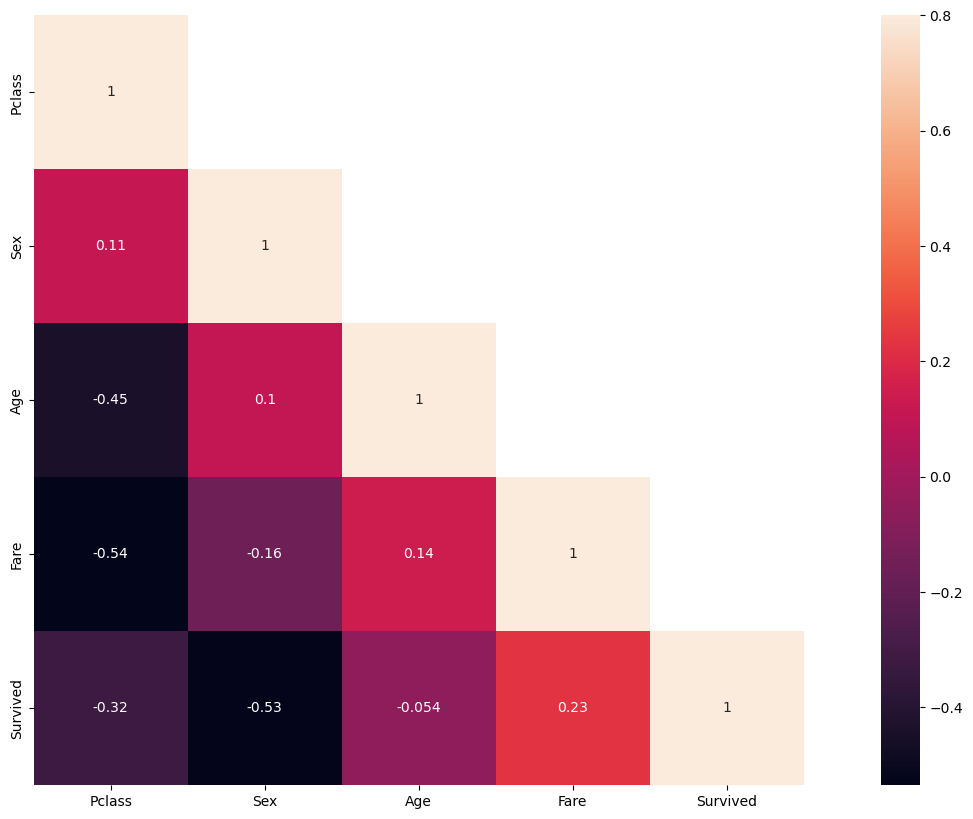

In [14]:
corrMatt = df_train[["Pclass","Sex","Age","Fare","Survived"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## Using Scikit Learn's Random Forest

* I wanted to test several different feautre counts to see what was the best
* Note: This was done before being taught cross validation methods.

- I put in what my opinion of a best guess is.

In [15]:
# Preparing subDataFrames to test how many variables could be best
df_forest_3 = df_train[['Pclass', 'Fare', 'Age']]
df_forest_4 = df_train[['Pclass', 'Fare', 'Age', 'Sex']]

In [16]:
df_forest_val_3 = df_val[['Pclass', 'Fare', 'Age']]
df_forest_val_4 = df_val[['Pclass', 'Fare', 'Age', 'Sex']]

#### Fitting to Train Data

In [17]:
rf3 = RandomForestClassifier(n_estimators=500, max_depth=5)
rf3.fit(df_forest_3, y_train)
round(rf3.score(df_forest_3, y_train),3)

0.812

In [18]:
rf4 = RandomForestClassifier(n_estimators=500, max_depth=8)
rf4.fit(df_forest_4, y_train)
round(rf4.score(df_forest_4, y_train),3)

0.93

#### Testing vs. Validation Data

In [19]:
# 'Pclass', 'Fare', 'Age'
print(rf3.feature_importances_)
print(round(rf3.score(df_forest_val_3, y_val),3))

[0.21450455 0.39886263 0.38663283]
0.832


In [20]:
# 'Pclass', 'Fare', 'Age', 'Sex'
print(rf4.feature_importances_)
print(round(rf4.score(df_forest_val_4, y_val),3))

[0.12005148 0.26915729 0.28485139 0.32593985]
0.911


#### We can see here that Sex is the most important feature by far, followed by Fare and Age with Class far behind.

* This is at odds with what our correlation heat map showed us.
* I was expecting Age to matter less than it does.

<AxesSubplot:>

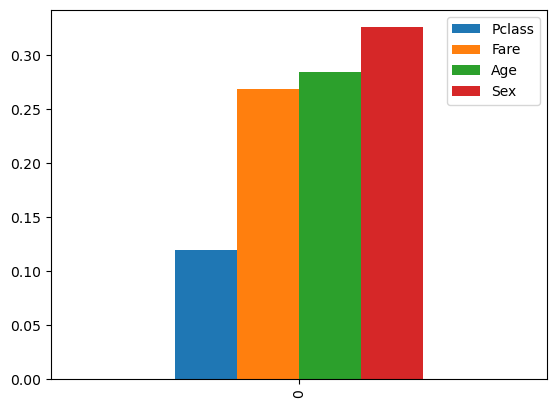

In [21]:
pd.DataFrame([rf4.feature_importances_], columns=['Pclass', 'Fare', 'Age', 'Sex']).plot.bar()

# Going through the steps with the test data

### Steps

* Replace Sex with numbers
* Replace Nan Ages with median values
* Replace Cabin with Deck numbers
* Fill Nan Fare Values with median for each class
* Create DataFrame using modified columns [['Sex', 'Fare', 'Deck', 'Age']]
* Create tests using RandomTree knowledge

In [22]:
test['PassengerId']	

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [23]:
# Replace Sex
test['Sex'] = test['Sex'].replace({'male' : 1, 'female': 0})
test['Sex'] = test['Sex'].astype(int)

In [24]:
# Fill in Nan Ages
test = fill_ages(test)

* Because I only needed this for loop once, I decided it didn't need to be a function.

In [25]:
# Filling Nan Fare
for num in range(1, 4):
    
    median = round(df_train.loc[(df_train['Pclass']==num)]['Fare'].median(), 0)

    test.loc[(test['Pclass']==num) & (test.Fare.isna()), 'Fare'] = median


In [26]:
test_3 = test[['Pclass', 'Fare', 'Age']]
test_4 = test[['Pclass', 'Fare', 'Age', 'Sex']]

In [27]:
test3_pred = pd.DataFrame(rf3.predict(test_3))
test3_pred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [28]:
test4_pred = pd.DataFrame(rf4.predict(test_4))
test4_pred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [29]:
id_list = []
for num in range(892, 1310):
    id_list.append(num)
    
id_df = pd.DataFrame(id_list)

In [30]:
try_2 = pd.merge(test4_pred, id_df, left_index=True, right_index=True)

In [31]:
try_2.columns = ['Survived', 'PassengerId']

In [32]:
try_2.set_index('PassengerId', inplace=True)

In [33]:
try_2.to_csv('./data/second_prediction.csv')

# Though this model showed significant improvement over my first model, it still only score a %76.5